# Auxiliary Functions

In [1]:
import requests
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def get_calendar_data():
    # request the json file with all of the calendar events in France
    res = requests.get('https://calendrier.api.gouv.fr/jours-feries/metropole.json')

    # convert the data to a dataframe
    df = pd.DataFrame.from_dict(res.json(),orient='index')
    df.columns = ['calendar_event']

    # parse the date index
    df.index = pd.to_datetime(df.index)

    # resample by day and fill the missing values
    df = df.resample('D').first().fillna("")

    # use the label encoder to convert to numerical values. 
    le = LabelEncoder()
    le.fit(df['calendar_event'])
    df['calendar_embedding'] = le.transform(df['calendar_event'])
    
    # return also the label encoder for parsing
    return df, le

national_holidays = get_calendar_data()[0][get_calendar_data()[0]['calendar_embedding'] != 0]
national_holidays.head(4)

,calendar_event,calendar_embedding
2003-01-01,1er janvier,3
2003-04-21,Lundi de Pâques,10
2003-05-01,1er mai,4
2003-05-08,8 mai,5


# OLD DATA

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy

from IPython.display import display, HTML
from statsmodels.tsa.seasonal import seasonal_decompose

display(HTML("<style>div.output_scroll { height: 25em; }</style>"))
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set(style="whitegrid")

data = pd.read_csv('../data/transactions_ds.csv', sep=';')

del data['price_ttc']

data['date'] = pd.to_datetime(data['date'])

data['year'] = data['date'].dt.year
data['year_week'] = data['date'].dt.isocalendar().week
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.day_name()

data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute

data['year_week'] = data['year_week'].astype('int64')

In [3]:
calendar = pd.read_json("../data/calendar.json")
weather = pd.read_csv('../data/weather_data.csv', sep=";")

weather['date'] = pd.to_datetime(weather['date'].str[:-6])

weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day
weather['hour'] = weather['date'].dt.hour

data = data.merge(weather, 
                  how='left', 
                  on=['year', 'month', 'day', 'hour'])

<AxesSubplot: xlabel='date', ylabel='temp'>

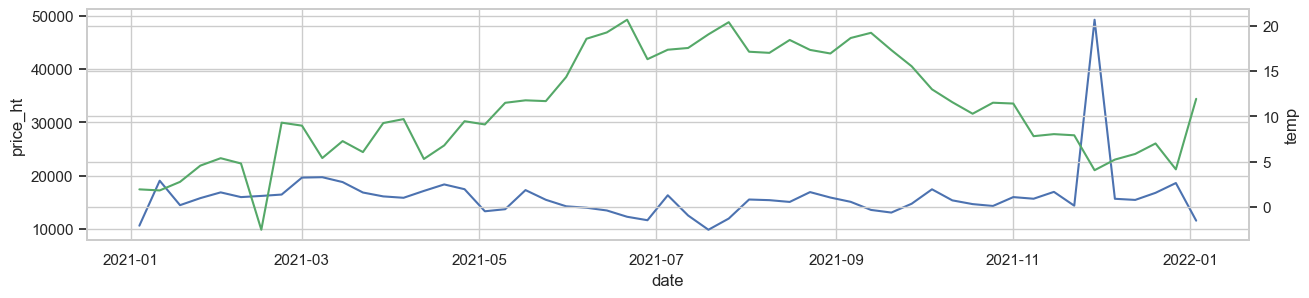

In [4]:
plot_1 = data[(data['year'] == 2021)].set_index('date').resample('W-MON')['price_ht'].sum()
plot_2 = weather[(weather['year'] == 2021)].set_index('date').resample('W-MON').mean()['temp']

fig, ax = plt.subplots(figsize=(15, 3))

sns.lineplot(data=plot_1, color="b")
ax2 = plt.twinx()
sns.lineplot(data=plot_2, color="g", ax=ax2)

# NEW DATA

# Preprocessing

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv('../data/stat_222_data/shop_1_transactions.csv', sep=';')

sns.set(style="whitegrid")

del data['price_ttc']

data['date'] = pd.to_datetime(data['date'])

items = pd.read_csv('../data/stat_222_data/shop_1_items_info.csv', sep=';')

calendar = pd.read_json("../data/calendar.json")

weather = pd.read_csv('../data/weather_data.csv', sep=";")

weather['date'] = pd.to_datetime(weather['date'].str[:-6])
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day
weather['hour'] = weather['date'].dt.hour

In [6]:
# Optional chunk
data['year'] = data['date'].dt.year
data['year_week'] = data['date'].dt.isocalendar().week
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.day_name()

data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute

data['year_week'] = data['year_week'].astype('int64')

## Remove outliers

In [7]:
data = data[data['price_ht'] >= 0]
mask = np.abs(scipy.stats.zscore(data[['quantity']])) < 2.5
data = data[mask['quantity']]

data_f = data[~((data['year'] == 2022) & (data['year_week'] > 32)) &
              ~((data['year'] == 2018) & (data['year_week'] < 11))]

In [8]:
sales = data_f[(data_f['price_ht'] < data_f['price_ht'].quantile(0.99)) &
               (data_f['price_ht'] > data_f['price_ht'].quantile(0.01))].set_index('date').resample('W-MON').sum()

sales = pd.DataFrame(sales['price_ht'])

# APPROACH 1: PREDICT TREND OF TOTAL SALES AND USE IT AS A COVARIATE FOR PREDICTING SALES OF THE MOST POPULAR GOODS

# Weekly Sales Predictions!

## Approach, discussed with Libor

Here, I take 7 days before and after $Y_t$

Overall approach:

$Y_t = TR_t + Season_t + Z_t$

- Predict $TR_t$ with rolling mean

- Predict $Season_t$ with adding month as a season variable

- Don't think about $Z_t$ for now

### Model Trend

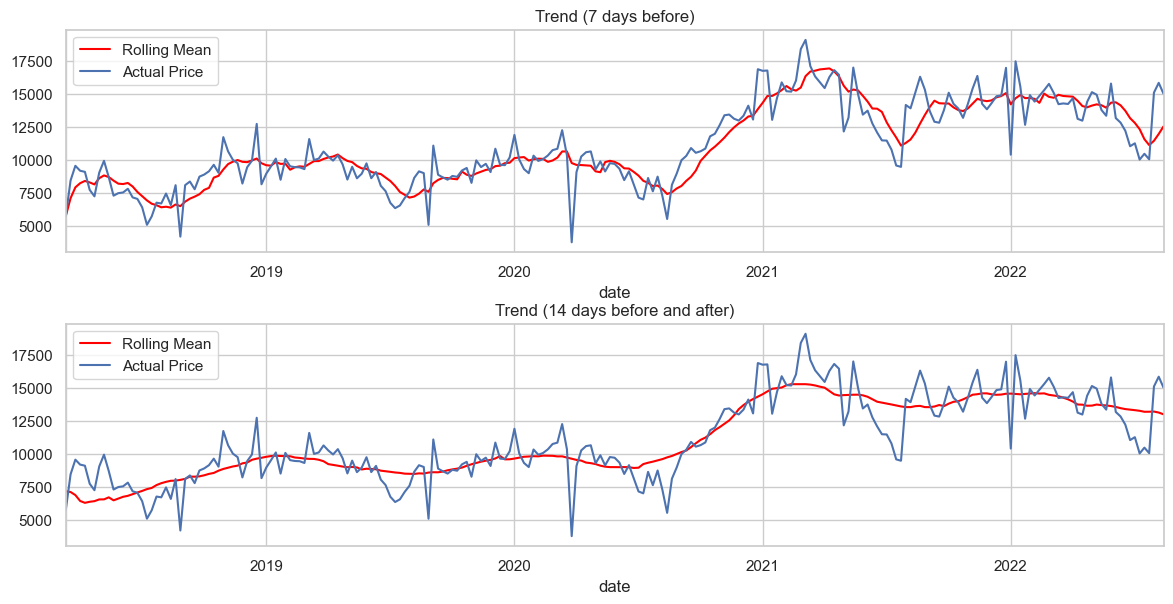

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

t = 14

sales.rolling(window=7,
              min_periods=1).mean().plot(ax=axs[0], 
                                         title='Trend (7 days before)',
                                         color='red',
                                         xlabel='Date')
sales.plot(ax=axs[0])
axs[0].legend(["Rolling Mean", "Actual Price"])
fig.tight_layout();

sales.shift(-t).rolling(2*t+1, 
                        min_periods=1).mean().plot(ax=axs[1], 
                                                   title=f'Trend ({t} days before and after)',
                                                   color='red',
                                                   xlabel='Date')
sales.plot(ax=axs[1])
axs[1].legend(["Rolling Mean", "Actual Price"]);

Add additional features: 
1) If national holiday (in the week)
2) Weather
3) Vacations (doesn't work)

In [10]:
trend = sales.shift(-t).rolling(2*t+1, min_periods=1).mean()

sales_no_trend = sales - trend
sales_no_trend.dropna(inplace=True)

sales_no_trend = sales_no_trend.reset_index()
sales_no_trend['month'] = sales_no_trend['date'].dt.month

In [11]:
national_holidays.head(1)

,calendar_event,calendar_embedding
2003-01-01,1er janvier,3


In [12]:
from datetime import timedelta, timezone

national_holidays.reset_index(inplace=True)
national_holidays['first_day_of_week'] = pd.to_datetime(national_holidays['index']\
.apply(lambda x: (x - timedelta(days=x.dayofweek))), utc=True)
national_holidays['calendar_event'] = 1

national_holidays.drop_duplicates(inplace=True)

del national_holidays['calendar_embedding']
del national_holidays['index']

In [13]:
rain = weather.set_index('date').resample('W-MON').mean()['temp'].reset_index()
rain['date'] = rain['date'].dt.tz_localize(timezone.utc)

In [14]:
### here some ideas about vacations. Doesn't work

holidays = calendar[calendar['type'] == 'holidays']
holidays['start_date'] = pd.to_datetime(holidays['start_date'])
holidays['end_date'] = pd.to_datetime(holidays['end_date'])

holidays['start_date'] = holidays['start_date'].dt.tz_localize(timezone.utc)
holidays['end_date'] = holidays['end_date'].dt.tz_localize(timezone.utc)

holidays = holidays[holidays['title'].str.contains('Zone C')]

tmp = sales_no_trend.merge(holidays, how='cross')
tmp = tmp[(tmp['date'] > tmp['start_date']) & 
          (tmp['date'] < tmp['end_date'])][['date', 'title']]
          
sales_no_trend = sales_no_trend.merge(tmp, how='left').fillna('No')

### Model Seasonality

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first').fit(sales_no_trend['month'].values.reshape(-1, 1))
months = encoder.transform(sales_no_trend['month'].values.reshape(-1, 1)).toarray()
months = pd.DataFrame(months, dtype=np.int16)
months.columns = encoder.get_feature_names_out(['Month'])

# This is an example how to get just 1 transformation
# encoder.transform(np.array([2]).reshape(-1,1)).toarray()

In [16]:
sales_no_trend = pd.concat([
    sales_no_trend,
    months
], axis=1)
del sales_no_trend['month']

In [17]:
sales_no_trend = sales_no_trend.merge(rain)
sales_no_trend = sales_no_trend.merge(national_holidays, 
                                      left_on='date',
                                      right_on='first_day_of_week',
                                      how='left').fillna(0)

#del sales_no_trend['date']
del sales_no_trend['first_day_of_week']
sales_no_trend.set_index('date', inplace=True)

sales_no_trend.drop_duplicates(inplace=True)

In [18]:
import statsmodels.api as sm

X = sales_no_trend.iloc[:,1:]
y = sales_no_trend.price_ht
model_sales = sm.OLS(y, X)

model_sales_fitted = model_sales.fit()
print(model_sales_fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:               price_ht   R-squared (uncentered):                   0.294
Model:                            OLS   Adj. R-squared (uncentered):              0.252
Method:                 Least Squares   F-statistic:                              6.994
Date:                Tue, 09 May 2023   Prob (F-statistic):                    2.80e-11
Time:                        17:33:35   Log-Likelihood:                         -1977.5
No. Observations:                 231   AIC:                                      3981.
Df Residuals:                     218   BIC:                                      4026.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [19]:
sales_fit = model_sales_fitted.get_prediction().summary_frame()['mean'].to_frame()

seasonal_comp = model_sales_fitted.get_prediction().summary_frame()['mean'].to_frame()
seasonal_comp.index = trend.index

sales_pred = pd.DataFrame(seasonal_comp['mean'] + trend['price_ht'], columns=['price_ht_pred'])

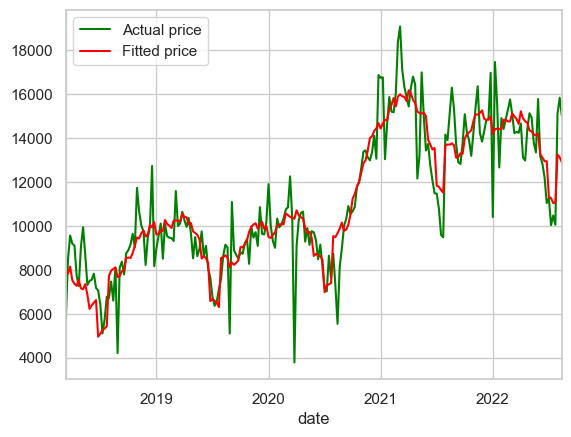

In [20]:
ax = plt.subplot()

sales.plot(ax=ax, color='green')
sales_pred.plot(ax=ax, color='red')
ax.legend(['Actual price', 'Fitted price']);

statsmodels.tsa.stattools.acf(sales['price_ht'] - sales_pred['price_ht_pred'])

### Model Errors

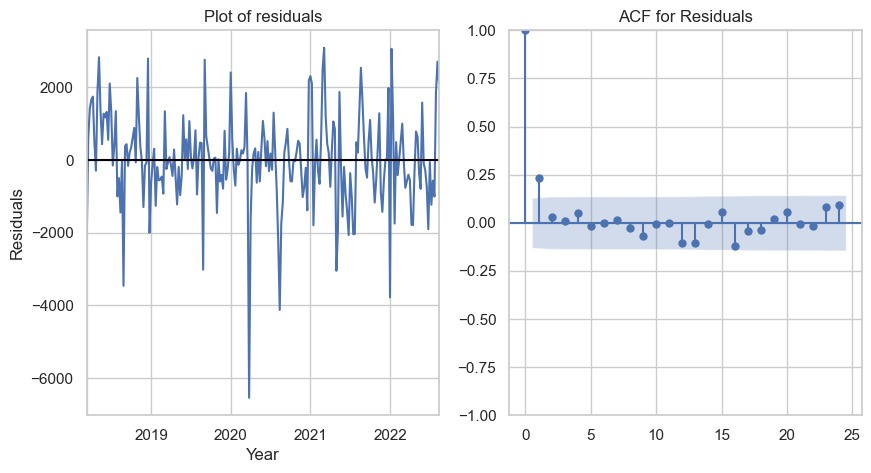

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

(sales['price_ht'] - sales_pred['price_ht_pred']).plot(title='Plot of residuals',
                                                       ylabel='Residuals',
                                                       xlabel='Year',
                                                       ax=ax[0])

residuals_total_price = (sales['price_ht'] - sales_pred['price_ht_pred'])
ax[0].axhline(color='black')
plot_acf(residuals_total_price, ax=ax[1], title='ACF for Residuals');

Seems we can and need to predict residuals as well to improve quality of prediction

In [22]:
from statsmodels.tsa.ar_model import AutoReg

model_total_sales_res = AutoReg(residuals_total_price, lags=1, trend='n').fit()
print(model_total_sales_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  231
Model:                     AutoReg(1)   Log Likelihood               -1961.386
Method:               Conditional MLE   S.D. of innovations           1222.712
Date:                Tue, 09 May 2023   AIC                           3926.772
Time:                        17:33:35   BIC                           3933.648
Sample:                    03-26-2018   HQIC                          3929.546
                         - 08-15-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.2364      0.064      3.690      0.000       0.111       0.362
                                    Roots                                    
                  Real          Imaginary           M

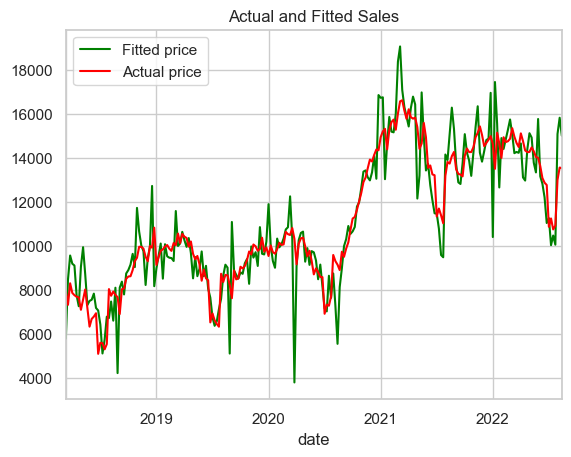

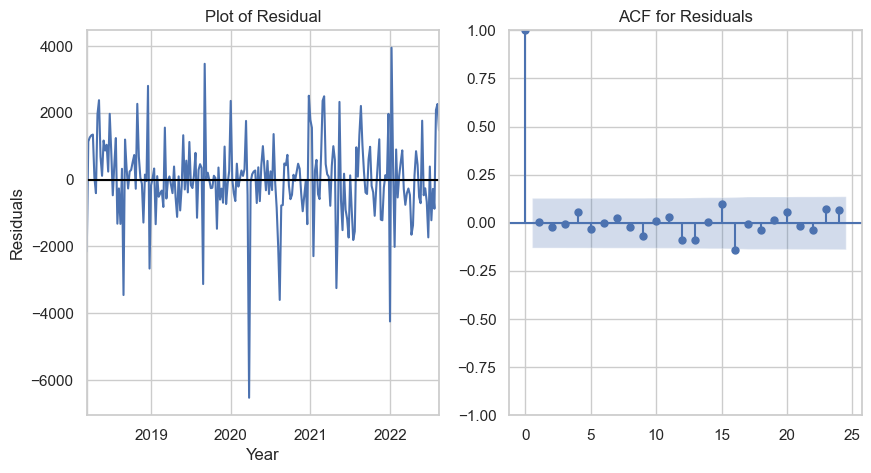

In [23]:
fit_residuals_total_price = model_total_sales_res.get_prediction().summary_frame()['mean'].fillna(0)

sales_pred = pd.DataFrame(seasonal_comp['mean'] + trend['price_ht'] + fit_residuals_total_price, 
                          columns=['price_ht_pred'])


ax = plt.subplot()
sales.plot(ax=ax, color='green')
sales_pred.plot(ax=ax, color='red')
ax.set_title('Actual and Fitted Sales')
ax.set_ylabel('')
ax.legend(['Fitted price', 'Actual price']);

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

(sales['price_ht'] - sales_pred['price_ht_pred']).plot(title='Plot of residuals',
                                                       ylabel='Residuals',
                                                       xlabel='Year',
                                                       ax=ax[0])

new_residuals_total_price = (sales['price_ht'] - sales_pred['price_ht_pred'])
ax[0].axhline(color='black')
ax[0].set_title('Plot of Residual')
plot_acf(new_residuals_total_price, ax=ax[1], title='ACF for Residuals');

Results:

$$
Y_t = Trend_t + Seasonality_t + Z_t,
$$

- $Trend_t$ - rolling mean
- $Seasonality_t$ - month dummy variable
- $Z_t$ - can be predicted with AR(1) model


## Prediction for Weekly Sales

### Predict trend

In [24]:
data_to_fit = sales['2020':]

X = [i for i in range(1, len(data_to_fit)+1)]
X = sm.add_constant(X)
Y = data_to_fit.values

model_linear_trend = sm.OLS(Y, X).fit()
fitted_linear_trend = model_linear_trend.get_prediction().summary_frame()['mean'].to_frame(name='Linear Trend')
fitted_linear_trend.set_index(data_to_fit.index, inplace=True)

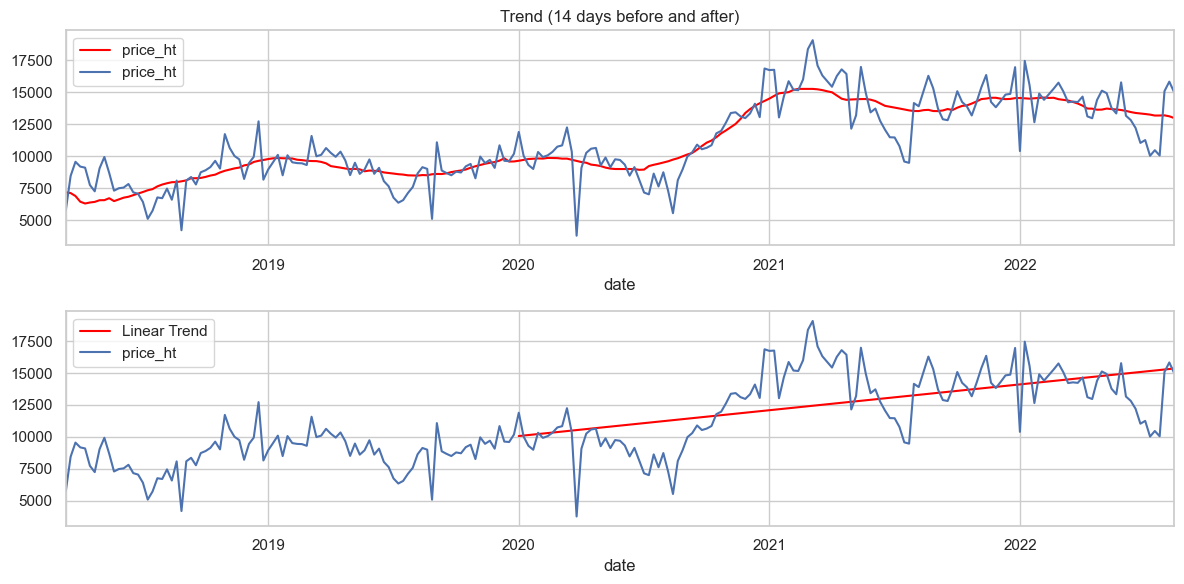

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

t = 14

sales.shift(-t).rolling(2*t+1, 
                        min_periods=1).mean().plot(ax=axs[0], 
                                                   title=f'Trend ({t} days before and after)',
                                                   color='red',
                                                   xlabel='Date')
sales.plot(ax=axs[0])



fitted_linear_trend.plot(ax=axs[1],
                         color='red')
sales.plot(ax=axs[1],
           color='C0')
fig.tight_layout();

$Trend_{t+1}$ is a next observation from linear trend:

In [26]:
pred_trend = model_linear_trend.get_prediction([1, len(X) + 1]).summary_frame()['mean'][0]

### Predict Seasonality

$Seasonality_{t+1}$ is an adjusted value for the next period:

In [27]:
def get_dummies_by_index(idx, m_encoder, holidays, weather):
    month_from_idx = idx.month.values.reshape(-1,1)
    year_from_idx = idx.year
    
    month = m_encoder.transform(month_from_idx).toarray()
    
    if_holiday = len(national_holidays['first_day_of_week'].to_frame().\
    merge(idx.\
          to_frame(name='first_day_of_week'), how='right'))
    
    holiday = pd.DataFrame({
        'calendar_event': [if_holiday]
    })
    
    avg_temp = pd.DataFrame(
        {'temp': [weather.set_index('date')[f'{year_from_idx[0]}-{month_from_idx[0][0]}']['temp'].mean()]}
    )
        
    month = pd.DataFrame(month, dtype=np.int16)
    month.columns = encoder.get_feature_names_out(['Month'])
    
    return pd.concat([
        month,
        holiday,
        avg_temp
    ], axis=1)

In [28]:
get_dummies_by_index(sales.index[-1:].shift(1)[-1:], encoder, national_holidays, weather)

,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,calendar_event,temp
0,0,0,0,0,0,0,1,0,0,0,0,1,21.886


In [29]:
next_period = sales.index[-1:].shift(1)[-1:]
next_period_seasonality = get_dummies_by_index(next_period, encoder, national_holidays, rain)

pred_seasonality = model_sales_fitted.get_prediction(next_period_seasonality).summary_frame()['mean'][0]

### Predict residuals

In [30]:
model_total_sales_res.forecast(1)[0]

500.00246728862345

### Combine Prediction

In [31]:
sales_next_period_pred = pred_seasonality + pred_trend + model_total_sales_res.forecast(1)[0]

In [32]:
sales_next_period_pred

17221.889744922028

# Main part: simulation!

We adjusted trend and consider only 4 last weeks


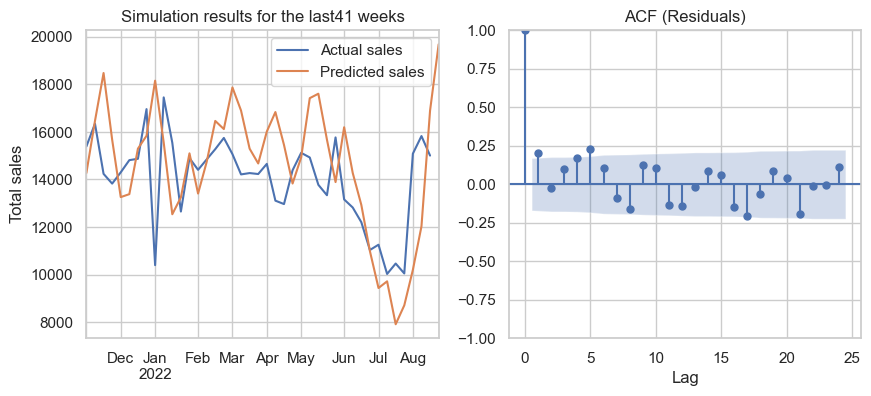

In [33]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

actual_data = sales.copy()

start_from = 190
t=14

observed_data = actual_data.iloc[:start_from,:]

predicted = observed_data.copy()
predicted.columns = ['price']

for week in range(1, len(actual_data)-start_from+2):
    # update main model
    
    # trend based on observed data
    current_trend = observed_data.shift(-t).rolling(2*t+1, min_periods=1).mean()
    sim_sales_no_trend = observed_data - current_trend
    sim_sales_no_trend.dropna(inplace=True)
    sim_sales_no_trend = sim_sales_no_trend.reset_index()
    sim_sales_no_trend['month'] = sim_sales_no_trend['date'].dt.month
    
    months = encoder.transform(sim_sales_no_trend['month'].values.reshape(-1, 1)).toarray()
    months = pd.DataFrame(months, dtype=np.int16)
    months.columns = encoder.get_feature_names_out(['Month'])
    sim_sales_no_trend = pd.concat([
        sim_sales_no_trend,
        months
    ], axis=1)
    del sim_sales_no_trend['month']
    
    sim_sales_no_trend = sim_sales_no_trend.merge(rain)
    sim_sales_no_trend = sim_sales_no_trend.merge(national_holidays, 
                                                  left_on='date',
                                                  right_on='first_day_of_week',
                                                  how='left').fillna(0)

    del sim_sales_no_trend['first_day_of_week']
    sim_sales_no_trend.set_index('date', inplace=True)

    sim_sales_no_trend.drop_duplicates(inplace=True)
    
    # model seasonality based on observed data
    X = sim_sales_no_trend.iloc[:,1:]
    y = sim_sales_no_trend.price_ht
    cur_model_sales = sm.OLS(y, X)

    cur_model_sales_fitted = cur_model_sales.fit()
    cur_sales_fit = cur_model_sales_fitted.get_prediction().summary_frame()['mean'].to_frame()
    cur_seasonal_comp = cur_model_sales_fitted.get_prediction().summary_frame()['mean'].to_frame()
    cur_seasonal_comp.index = current_trend.index
    cur_sales_fitted = pd.DataFrame(cur_seasonal_comp['mean'] + current_trend['price_ht'], 
                                    columns=['price_ht_pred'])
    

    cur_residuals_total_price = (observed_data['price_ht'] - cur_sales_fitted['price_ht_pred'])    
    
    model_total_sales_res = AutoReg(cur_residuals_total_price, 
                                    lags=2, 
                                    trend='n').fit()
    
    cur_fit_residuals_total_price = model_total_sales_res.get_prediction().summary_frame()['mean'].fillna(0)
    
    cur_sales_fit = pd.DataFrame(cur_seasonal_comp['mean'] + \
                                 current_trend['price_ht'] + \
                                 cur_fit_residuals_total_price, 
                                 columns=['price_ht_pred'])
    
    # now make prediction about next period using previous results
    
    # trend
    last_weeks_for_trend = 4
    data_to_fit = observed_data.iloc[-last_weeks_for_trend:].copy()

    data_to_fit['pct_change'] = data_to_fit.pct_change().shift(-1)

    data_to_fit['pct_change_2'] = np.where(data_to_fit['pct_change'] > 0.35, 0.1, 
                                   np.where(data_to_fit['pct_change'] < -0.35, -0.1, data_to_fit['pct_change']))

    data_to_fit['recovered'] = (data_to_fit['price_ht'] * (1 + data_to_fit['pct_change_2'])).shift()

    del data_to_fit['pct_change']
    del data_to_fit['pct_change_2']
    data_to_fit = data_to_fit.T.fillna(data_to_fit.mean(axis=1)).T
    data_to_fit['price_ht'] = data_to_fit['recovered']
    del data_to_fit['recovered']


    X = [i for i in range(1, len(data_to_fit)+1)]
    X = sm.add_constant(X)
    Y = data_to_fit.values

    cur_model_linear_trend = sm.OLS(Y, X).fit()
    fitted_linear_trend = cur_model_linear_trend.get_prediction().summary_frame()['mean'].to_frame(name='Linear Trend')
    fitted_linear_trend.set_index(data_to_fit.index, inplace=True)
    pred_trend = cur_model_linear_trend.get_prediction([1, len(X) + 1]).summary_frame()['mean'][0]
    
    # seasonality
    next_period = observed_data.index[-1:].shift(1)[-1:]
    next_period_seasonality = get_dummies_by_index(next_period, encoder, national_holidays, rain)
    pred_seasonality = cur_model_sales_fitted.get_prediction(next_period_seasonality).summary_frame()['mean'][0]
    
    # residuals
    pred_residuals = model_total_sales_res.forecast(1)[0]
    
    prediction = pred_trend + pred_seasonality + pred_residuals
#    print(f'PREDICTED: \nTrend:{pred_trend}, \nSeasonality:{pred_seasonality}, \nResiduals:{pred_residuals}')

    pred_df = pd.DataFrame({
        'price': [prediction]
    })
    pred_df.set_index(next_period, inplace=True)
    
    predicted = predicted.append(pred_df)
    
    # add new data to observed data
    next_week_actual = actual_data.iloc[:start_from+week,:].iloc[-1:, :]
    observed_data = observed_data.append(next_week_actual)

print(f'We adjusted trend and consider only {last_weeks_for_trend} last weeks')
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

predicted_periods = len(sales) - start_from
actual_data.iloc[start_from:,:].plot(ax=axs[0])
predicted.iloc[start_from:,:].plot(ax=axs[0])

res = (actual_data['price_ht'] - predicted['price']).dropna()
plot_acf(res, ax=axs[1], alpha=0.01)

axs[0].legend(['Actual sales', 'Predicted sales'])
axs[0].set_title(f'Simulation results for the last{predicted_periods} weeks')
axs[0].set_xlabel('')
axs[0].set_ylabel('Total sales')

axs[1].set_title('ACF (Residuals)')
axs[1].set_xlabel('Lag');

## Now, let's fit a model for one of the most popular good

In [34]:
temp = data_f.groupby(['item_id'])['transaction_id'].count().sort_values(ascending=False).reset_index()
temp['percentage'] = 100 * temp['transaction_id']  / temp['transaction_id'].sum()
top_items = temp[['item_id', 'percentage']]['item_id'].to_list()
temp[['item_id', 'percentage']].head(5)

,item_id,percentage
0,IT-11,13.144
1,IT-54,8.618
2,IT-26,4.408
3,IT-29,4.364
4,IT-28,4.148


In [35]:
IT_11 = data_f[data_f['item_id'] == 'IT-11'][['quantity', 'price_ht', 'date']]
IT_11 = IT_11[['price_ht', 'date']].set_index('date').resample('W-MON').sum()

In [36]:
Y_t = sales_pred.values
Y_t = sm.add_constant(Y_t)
X_t = IT_11.values

model_it11 = sm.OLS(X_t, Y_t)
model_it11_fitted = model_it11.fit()
print(model_it11_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     571.6
Date:                Tue, 09 May 2023   Prob (F-statistic):           3.56e-64
Time:                        17:33:36   Log-Likelihood:                -1575.0
No. Observations:                 231   AIC:                             3154.
Df Residuals:                     229   BIC:                             3161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -355.0737     57.658     -6.158      0.0

In [37]:
IT_11_pred = pd.DataFrame(model_it11_fitted.get_prediction().summary_frame()['mean'])
IT_11_pred.columns = ['price_ht'] # fitted
IT_11_pred.set_index(IT_11.index, inplace=True)

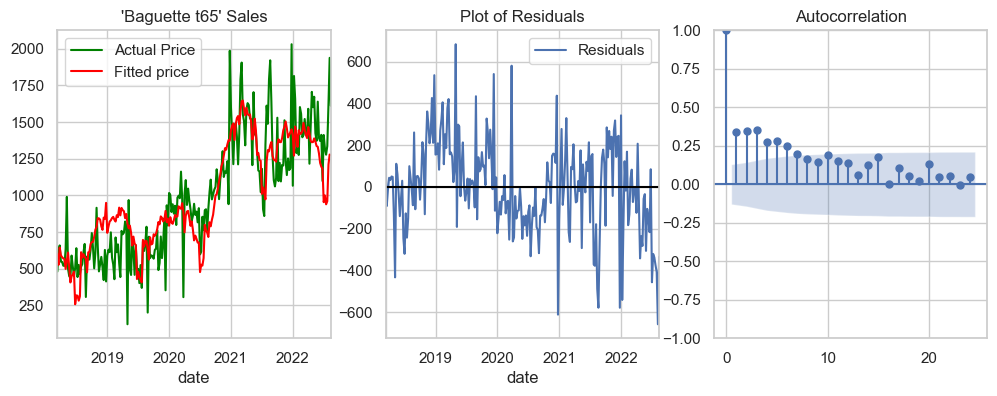

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

IT_11.plot(ax=ax[0], color='green')
IT_11_pred.plot(ax=ax[0], color='red')
ax[0].set_title(f"'{list(items[items['id'] == 'IT-11']['display_name'])[0]}' Sales")
ax[0].legend(['Actual Price', 'Fitted price'])

IT_11_res = IT_11_pred - IT_11
IT_11_res.plot(ax=ax[1]);
ax[1].axhline(y=0, color='black', linestyle='-')
ax[1].set_title('Plot of Residuals')
ax[1].legend(['Residuals'])

plot_acf(IT_11_res, ax=ax[2]);

In [39]:
def get_model_for_item(item):
    item_df = data_f[data_f['item_id'] == item][['quantity', 'price_ht', 'date']]
    item_df = item_df[['price_ht', 'date']].set_index('date').resample('W-MON').sum()
    
    Y_t = sales_pred.values
    Y_t = sm.add_constant(Y_t)
    X_t = item_df.values

    model_item = sm.OLS(X_t, Y_t).fit()
        
    return f'Coefficient for beta: {model_item.params[1]:.2f} ({model_item.pvalues[0]:.2f}). R2: {model_item.rsquared:.2f}'

In [40]:
for item in top_items[:6]:
    print(f'{item}: {get_model_for_item(item)}')

IT-11: Coefficient for beta: 0.12 (0.00). R2: 0.71
IT-54: Coefficient for beta: 0.07 (0.01). R2: 0.60
IT-26: Coefficient for beta: 0.03 (0.00). R2: 0.45
IT-29: Coefficient for beta: 0.03 (0.00). R2: 0.35
IT-28: Coefficient for beta: 0.03 (0.00). R2: 0.38
IT-38: Coefficient for beta: 0.06 (0.00). R2: 0.61


In [41]:
def get_fitted_for_item(item):
    item_df = data_f[data_f['item_id'] == item][['quantity', 'price_ht', 'date']]
    item_df = item_df[['price_ht', 'date']].set_index('date').resample('W-MON').sum()
    
    Y_t = sales_pred.values
    Y_t = sm.add_constant(Y_t)
    X_t = item_df.values

    model_item = sm.OLS(X_t, Y_t).fit()
    
    item_name = items[items['id'] == item]['display_name'].values[0]
    
    item_pred = model_item.get_prediction().summary_frame()['mean'].to_frame(name=item_name)
    item_pred.set_index(item_df.index, inplace=True)
    
    return item_pred

In [42]:
items_df = pd.DataFrame()

for item in top_items[:6]:
    items_df = pd.concat([
        items_df,
        get_fitted_for_item(item)
    ], axis=1)

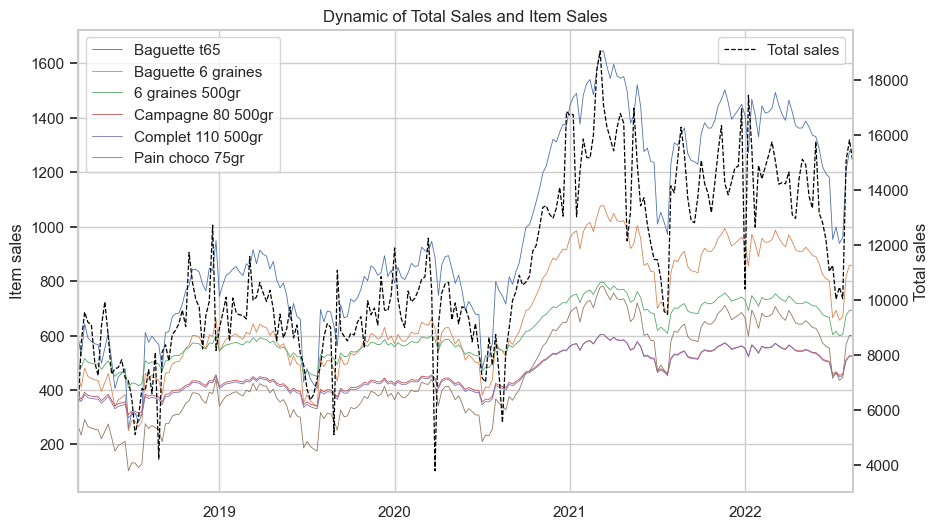

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()

items_df.plot(ax=ax1, linewidth=0.6)
sales.plot(ax=ax2, color='black', linestyle='dashed', linewidth=0.9)

ax1.set_title('Dynamic of Total Sales and Item Sales')
ax1.set_xlabel('')
ax1.set_ylabel('Item sales')
ax2.set_ylabel('Total sales')
ax2.legend(['Total sales'])
ax2.grid();

## Predictions: Approach 2. Here we use coefficients as given

In [44]:
past_weeks = 5

sales_lw = sales.iloc[-past_weeks:,:]
sales_pred_lw = sales_pred.iloc[-past_weeks:,:]

In [45]:
X = [i for i in range(1, len(sales_lw)+1)]
X = sm.add_constant(X)
Y = sales_lw.values

model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     7.348
Date:                Tue, 09 May 2023   Prob (F-statistic):             0.0731
Time:                        17:33:37   Log-Likelihood:                -43.106
No. Observations:                   5   AIC:                             90.21
Df Residuals:                       3   BIC:                             89.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8829.3000   1817.734      4.857      0.0

In [46]:
new_period = np.array([[1, 6]])
X_tplus1 = np.concatenate((X, new_period))

data_tplus1 = pd.DataFrame(results.get_prediction(X_tplus1).summary_frame(alpha=0.05)['mean'])

idx = sales.iloc[-past_weeks:,:].index
idx = idx.union(idx.shift(1)[-1:])
data_tplus1.set_index(idx, inplace=True)

Text(0, 0.5, 'Total sales')

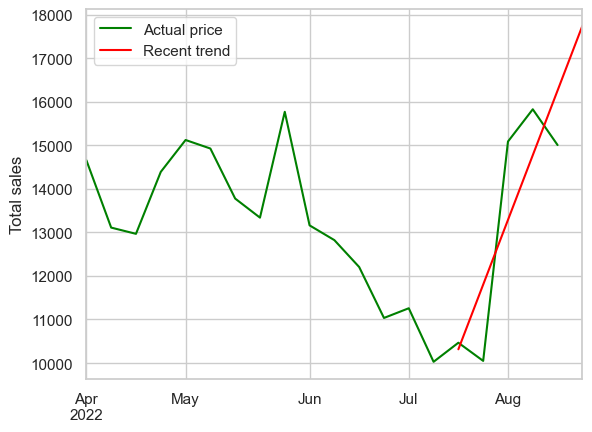

In [47]:
ax = plt.subplot()

sales.iloc[-20:,:].plot(ax=ax, color='green')
data_tplus1.plot(ax=ax, color='red')
ax.legend(['Actual price', 'Recent trend'])
ax.set_xlabel('')
ax.set_ylabel('Total sales')

In [48]:
pred_sales = results.get_prediction(new_period).summary_frame(alpha=0.05)['mean'][0]
y_tp1 = model_it11_fitted.get_prediction(np.array([[1, pred_sales]])).summary_frame()['mean']

idx = IT_11.iloc[-past_weeks:,:].index[-1:]
idx = idx.union(idx.shift(1)[-1:])

data_for_plot = pd.DataFrame({
    'values': [IT_11['price_ht'][-1], y_tp1[0]]
})
data_for_plot.set_index(idx, inplace=True)

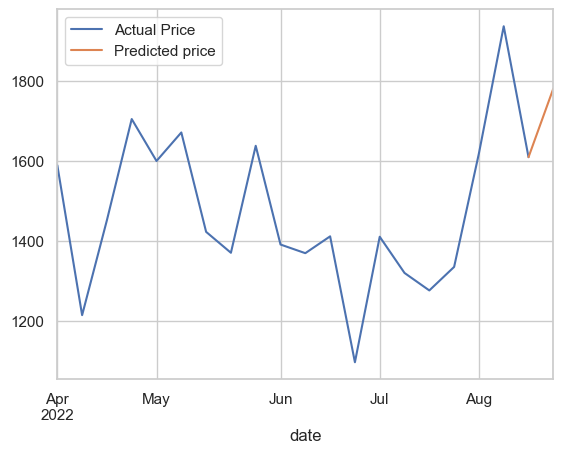

In [49]:
ax = plt.subplot()

IT_11.iloc[-20:,:].plot(ax=ax)
data_for_plot.plot(ax=ax)

ax.legend(['Actual Price', 'Predicted price']);

## Combine the idea for one good to see how it works

In [50]:
past_weeks = 5

predictions = IT_11.iloc[0:past_weeks-1, :]

for i in range(len(sales) - past_weeks + 1):
    
    sales_lw = sales.iloc[i:i+past_weeks, :]
    
    X = [i for i in range(1, len(sales_lw)+1)]
    X = sm.add_constant(X)
    Y = sales_lw.values

    model = sm.OLS(Y, X)
    results = model.fit()
    
    new_period = np.array([[1, past_weeks+1]])
    
    sales_1week_pred = results.get_prediction(new_period).summary_frame(alpha=0.05)['mean'][0]
    item_1week_pred = model_it11_fitted.get_prediction(np.array([[1, sales_1week_pred]])).summary_frame()['mean']
    
    idx = IT_11.iloc[i:i+past_weeks, :].index[-1:]
    
    item_1week_pred = pd.DataFrame({
        'values': [item_1week_pred[0]]
    })
    item_1week_pred.columns = ['price_ht']
    item_1week_pred.set_index(pd.DatetimeIndex(idx), inplace=True)
    
    predictions = pd.concat([
        predictions,
        item_1week_pred
    ])

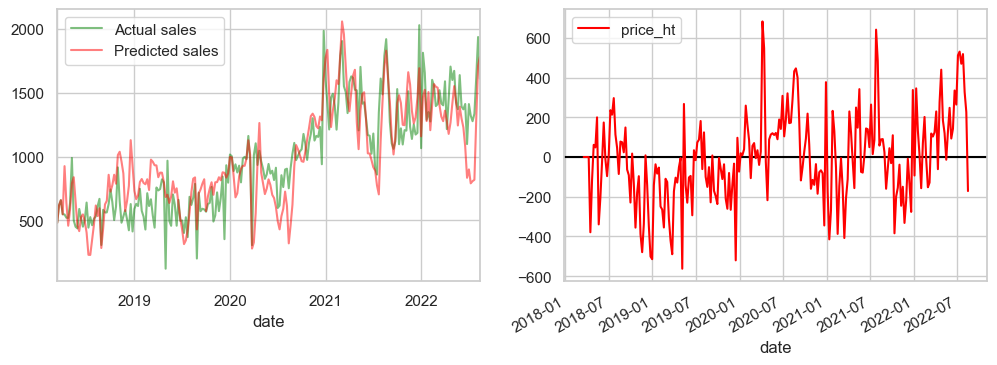

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
IT_11.plot(ax=ax[0], color='green', alpha=0.5)
predictions.plot(ax=ax[0], color='red', alpha=0.5)
ax[0].legend(['Actual sales', 'Predicted sales'])

residuals = IT_11 - predictions
ax[1].axhline(y=0, color='black', linestyle='-')
residuals.plot(ax=ax[1], color='red');

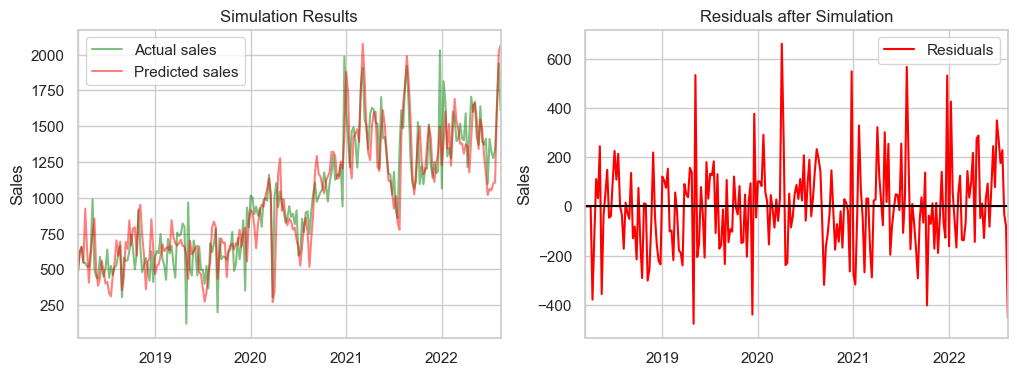

In [52]:
import statsmodels

model_residuals = AutoReg(residuals, lags=6, trend='n').fit()

residuals_predictions = pd.DataFrame(model_residuals.get_prediction().summary_frame().fillna(0)['mean'])
residuals_predictions.columns = ['price_ht']

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
IT_11.plot(ax=ax[0], color='green', alpha=0.5)
(predictions + residuals_predictions).plot(ax=ax[0], color='red', alpha=0.5)
ax[0].legend(['Actual sales', 'Predicted sales'])
ax[0].set_title('Simulation Results')
ax[0].set_xlabel('')
ax[0].set_ylabel('Sales')

residuals = IT_11 - (predictions + residuals_predictions)
residuals.plot(ax=ax[1], color='red')
ax[1].axhline(y=0, color='black', linestyle='-')
ax[1].set_title('Residuals after Simulation')
ax[1].set_xlabel('')
ax[1].set_ylabel('Sales')
ax[1].legend(['Residuals']);

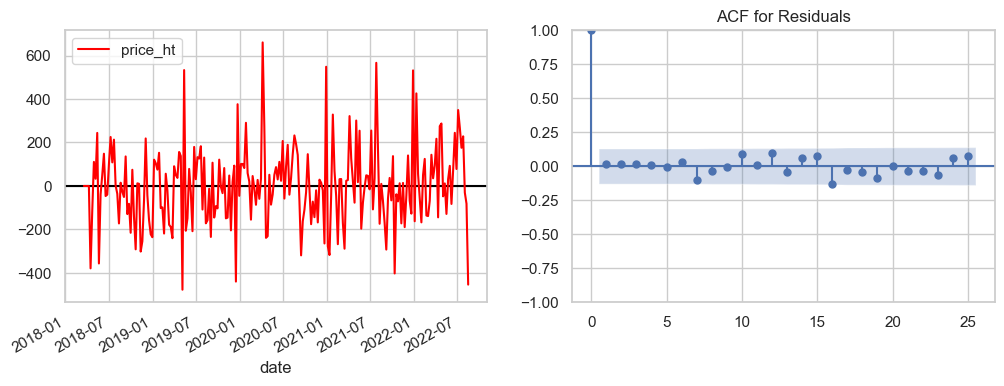

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].axhline(y=0, color='black', linestyle='-')
(residuals).plot(ax=ax[0], color='red')
plot_acf(residuals, ax=ax[1], lags=25)
ax[1].set_title('ACF for Residuals');

# Daily trend and predictions

### Approach 1: make very short window for rolling mean

In [54]:
t=[2, 1]

daily_quantity = data_f[(data_f['quantity'] < data_f['quantity'].quantile(0.99)) &
                        (data_f['quantity'] > data_f['quantity'].quantile(0.01))].\
set_index('date').resample('D').sum()
daily_quantity = pd.DataFrame(daily_quantity['quantity'])

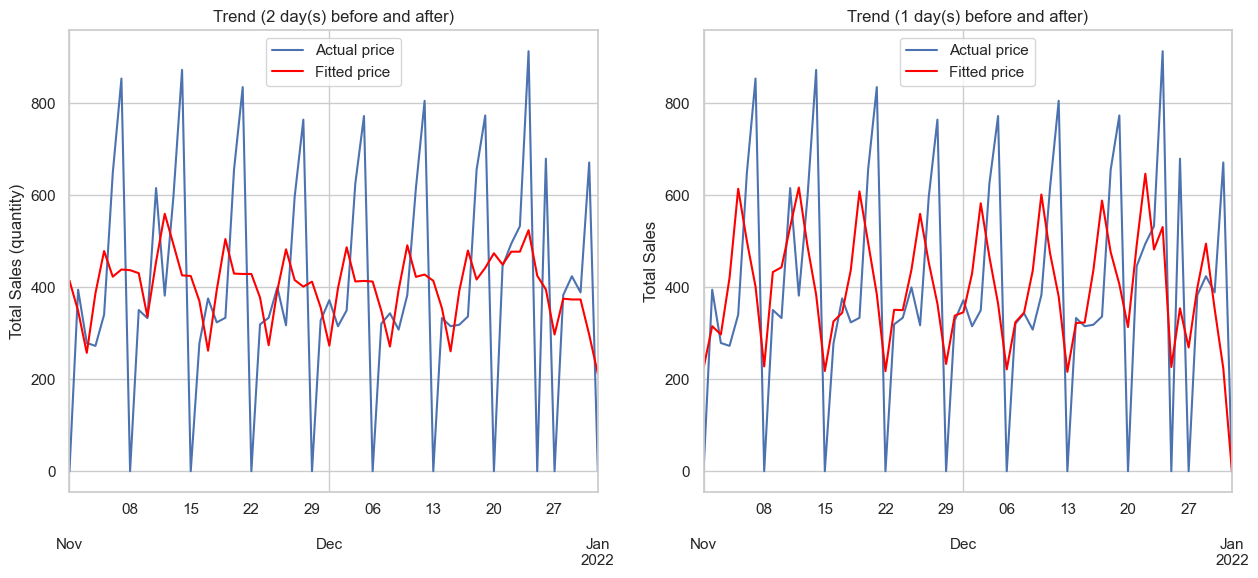

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

daily_quantity["2021-11-01":"2022-01-01"].plot(ax=axs[0])
axs[0].set_ylabel('Total Sales (quantity)')
axs[0].set_title('Total Daily Sales (from Nov-2021 to Dec-2021)')

daily_quantity["2021-11-01":"2022-01-01"].plot(ax=axs[1])
axs[1].set_ylabel('Total Sales')
axs[1].set_title('Total Daily Sales (from Nov-2021 to Dec-2021)')


rolling_daily_quantity = daily_quantity.shift(-t[0]).rolling(2*t[0]+1, 
                                                    min_periods=1).mean()
rolling_daily_quantity["2021-11-01":"2022-01-01"].plot(ax=axs[0], 
                                                    title=f'Trend ({t[0]} day(s) before and after)',
                                                    color='red')

rolling_daily_quantity = daily_quantity.shift(-t[0]).rolling(2*t[1]+1, 
                                                    min_periods=1).mean()
rolling_daily_quantity["2021-11-01":"2022-01-01"].plot(ax=axs[1],
                                                    title=f'Trend ({t[1]} day(s) before and after)',
                                                    color='red');
axs[0].legend(['Actual price', 'Fitted price'])
axs[1].legend(['Actual price', 'Fitted price'])

axs[0].set_xlabel('')
axs[1].set_xlabel('');

In [56]:
daily_s_no_trend = rolling_daily_quantity - daily_quantity
daily_s_no_trend.reset_index(inplace=True)
daily_s_no_trend['weekday'] = daily_s_no_trend['date'].dt.day_name()

daily_s_no_trend = pd.get_dummies(daily_s_no_trend, columns=['weekday'], drop_first=True)
del daily_s_no_trend['date']

In [57]:
import statsmodels.api as sm

X = daily_s_no_trend.iloc[:,1:]
y = daily_s_no_trend['quantity']

model_daily_quantity = sm.OLS(y, X).fit()

In [58]:
print(model_daily_quantity.summary())

                                 OLS Regression Results                                
Dep. Variable:               quantity   R-squared (uncentered):                   0.656
Model:                            OLS   Adj. R-squared (uncentered):              0.655
Method:                 Least Squares   F-statistic:                              511.6
Date:                Tue, 09 May 2023   Prob (F-statistic):                        0.00
Time:                        17:33:39   Log-Likelihood:                         -10045.
No. Observations:                1613   AIC:                                  2.010e+04
Df Residuals:                    1607   BIC:                                  2.013e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [59]:
seasonality_daily_quantity = pd.DataFrame(model_daily_quantity.get_prediction().summary_frame()['mean'])
seasonality_daily_quantity.columns = ['quantity']
seasonality_daily_quantity.set_index(rolling_daily_quantity.index, inplace=True)

total_daily_quantity_fitted = rolling_daily_quantity + seasonality_daily_quantity

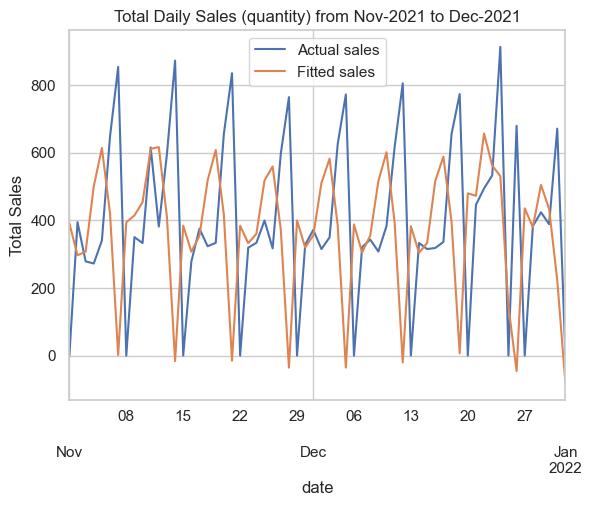

In [60]:
ax = plt.subplot()

daily_quantity["2021-11-01":"2022-01-01"].plot(ax=ax)
ax.set_ylabel('Total Sales')
ax.set_title('Total Daily Sales (quantity) from Nov-2021 to Dec-2021')

total_daily_quantity_fitted["2021-11-01":"2022-01-01"].plot(ax=ax)
ax.legend(['Actual sales', 'Fitted sales']);

Conclusion here: we are not exact in predictions

### Approach 2: make daily predictions as an average of previous weeks

In [61]:
daily_quantity['plus_7_days'] = daily_quantity['quantity'].shift(-7)
daily_quantity['minus_7_days'] = daily_quantity['quantity'].shift(7)
# daily_quantity['plus_14_days'] = daily_quantity['quantity'].shift(-14)
# daily_quantity['minus_14_days'] = daily_quantity['quantity'].shift(14)

daily_quantity = daily_quantity.T.fillna(value=daily_quantity.mean(axis=1)).T
daily_quantity['quantity_trend'] = daily_quantity.mean(axis=1)

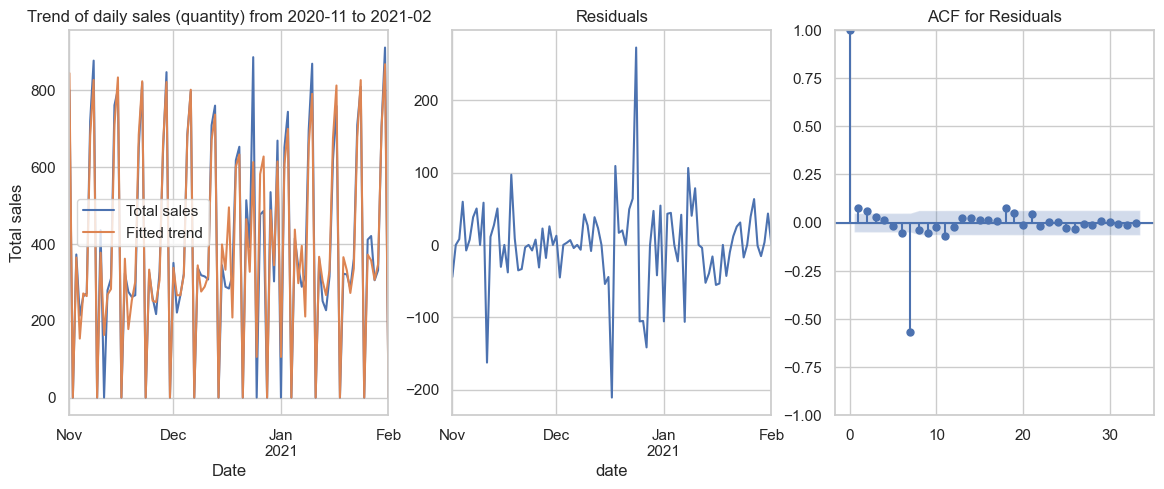

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
daily_quantity.loc["2020-11-01":"2021-02-01", 'quantity'].plot(ax=axs[0])
daily_quantity.loc["2020-11-01":"2021-02-01", 'quantity_trend'].plot(ax=axs[0])
axs[0].set_title('Trend of daily sales (quantity) from 2020-11 to 2021-02')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Total sales')
axs[0].legend(['Total sales', 'Fitted trend'])

residuals = daily_quantity['quantity'] - daily_quantity['quantity_trend']
residuals.loc["2020-11-01":"2021-02-01"].plot(ax=axs[1])
axs[1].set_title('Residuals')
plot_acf(residuals, ax=axs[2])
axs[2].set_title('ACF for Residuals');

In [63]:
import pmdarima as pm

model = pm.auto_arima(residuals, seasonal=True, m=7)

model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 0, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(residuals, 
                        order=model.get_params()['order'], 
                        seasonal_order=model.get_params()['seasonal_order']).fit(disp=0)

final_fitted_d_quantity = daily_quantity['quantity_trend'] + model_sarimax.get_prediction().summary_frame()['mean']

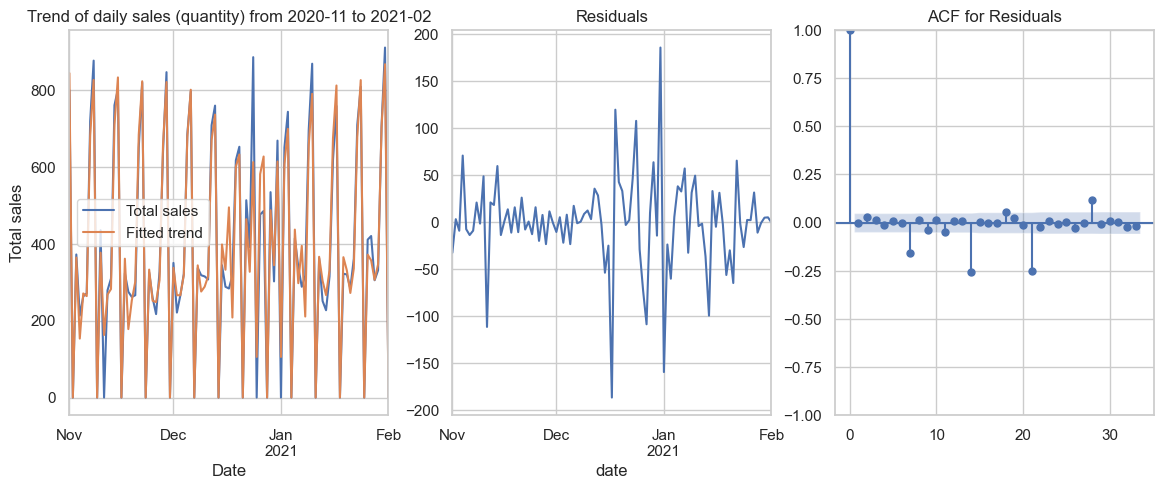

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
daily_quantity.loc["2020-11-01":"2021-02-01", 'quantity'].plot(ax=axs[0])
daily_quantity.loc["2020-11-01":"2021-02-01", 'quantity_trend'].plot(ax=axs[0])
axs[0].set_title('Trend of daily sales (quantity) from 2020-11 to 2021-02')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Total sales')
axs[0].legend(['Total sales', 'Fitted trend'])

residuals = daily_quantity['quantity'] - final_fitted_d_quantity
residuals.loc["2020-11-01":"2021-02-01"].plot(ax=axs[1])
axs[1].set_title('Residuals')
plot_acf(residuals, ax=axs[2])
axs[2].set_title('ACF for Residuals');

<AxesSubplot: xlabel='date'>

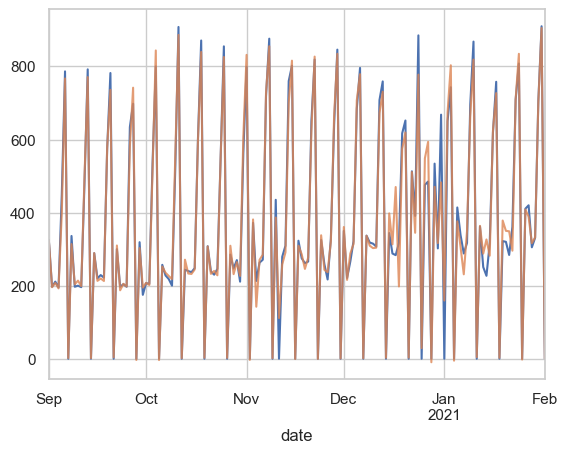

In [66]:
ax = plt.subplot()
daily_quantity.loc["2020-09-01":"2021-02-01", 'quantity'].plot(ax=ax)
final_fitted_d_quantity.loc["2020-09-01":"2021-02-01"].plot(ax=ax, alpha=0.8)

### Approach 3: smooth trend

In [67]:
t = [28, 21]

daily_quantity = data_f[(data_f['quantity'] < data_f['quantity'].quantile(0.99)) &
                        (data_f['quantity'] > data_f['quantity'].quantile(0.01))].set_index('date').resample('D').sum()
daily_quantity = pd.DataFrame(daily_quantity['quantity'])

daily_quantity.reset_index(inplace=True)
daily_quantity['weekday'] = daily_quantity['date'].dt.day_name()

daily_quantity = daily_quantity[daily_quantity['weekday'] != 'Sunday']

daily_quantity.set_index('date', inplace=True)

del daily_quantity['weekday']

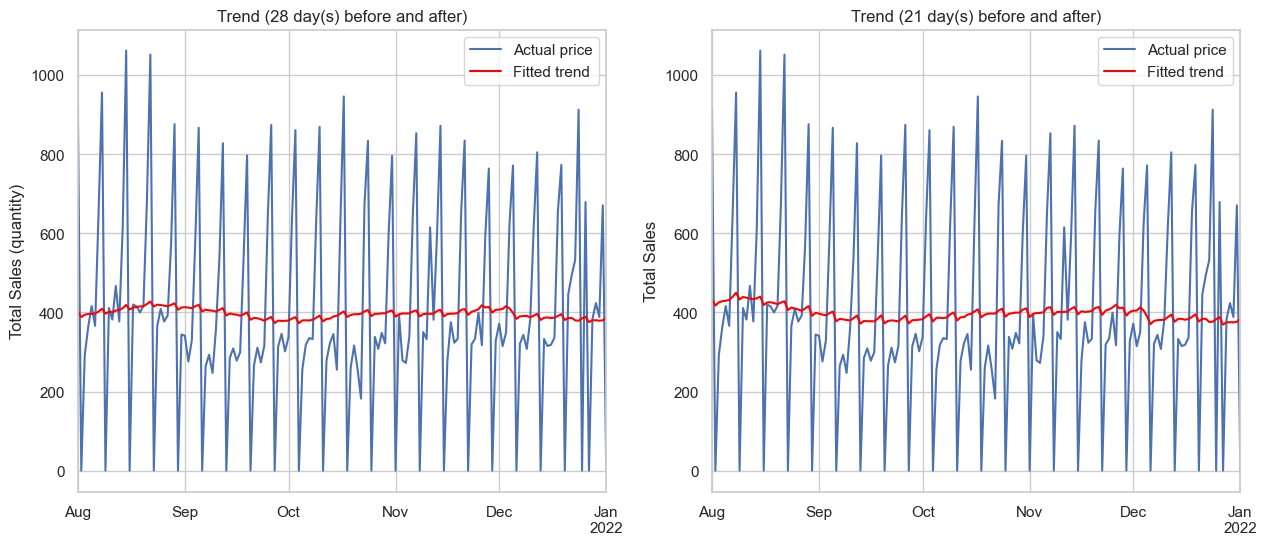

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

daily_quantity["2021-08-01":"2022-01-01"].plot(ax=axs[0])
axs[0].set_ylabel('Total Sales (quantity)')
axs[0].set_title('Total Daily Sales (from Nov-2021 to Dec-2021)')

daily_quantity["2021-08-01":"2022-01-01"].plot(ax=axs[1])
axs[1].set_ylabel('Total Sales')
axs[1].set_title('Total Daily Sales (from Nov-2021 to Dec-2021)')


rolling_daily_quantity = daily_quantity.shift(-t[0]).rolling(2*t[0]+1, 
                                                    min_periods=1).mean()
rolling_daily_quantity["2021-08-01":"2022-01-01"].plot(ax=axs[0], 
                                                    title=f'Trend ({t[0]} day(s) before and after)',
                                                    color='red')

rolling_daily_quantity = daily_quantity.shift(-t[0]).rolling(2*t[1]+1, 
                                                    min_periods=1).mean()
rolling_daily_quantity["2021-08-01":"2022-01-01"].plot(ax=axs[1],
                                                    title=f'Trend ({t[1]} day(s) before and after)',
                                                    color='red');
axs[0].legend(['Actual price', 'Fitted trend'])
axs[1].legend(['Actual price', 'Fitted trend'])

axs[0].set_xlabel('')
axs[1].set_xlabel('');

In [69]:
from sklearn.preprocessing import OneHotEncoder

daily_s_no_trend = daily_quantity - rolling_daily_quantity
daily_s_no_trend.reset_index(inplace=True)
daily_s_no_trend['weekday'] = daily_s_no_trend['date'].dt.day_name()

encoder = OneHotEncoder(drop='first').fit(daily_s_no_trend['weekday'].values.reshape(-1, 1))
weekday = encoder.transform(daily_s_no_trend['weekday'].values.reshape(-1, 1)).toarray()
weekday = pd.DataFrame(weekday, dtype=np.int16)
weekday.columns = encoder.get_feature_names_out(['weekday'])

del daily_s_no_trend['date']

daily_s_no_trend = pd.concat([
    daily_s_no_trend,
    weekday
], axis=1)
del daily_s_no_trend['weekday']

In [70]:
import statsmodels.api as sm

X = daily_s_no_trend.iloc[:,1:]
y = daily_s_no_trend['quantity']

model_daily_quantity = sm.OLS(y, X).fit()

print(model_daily_quantity.summary())

                                 OLS Regression Results                                
Dep. Variable:               quantity   R-squared (uncentered):                   0.822
Model:                            OLS   Adj. R-squared (uncentered):              0.821
Method:                 Least Squares   F-statistic:                              1235.
Date:                Tue, 09 May 2023   Prob (F-statistic):                        0.00
Time:                        17:33:56   Log-Likelihood:                         -9672.3
No. Observations:                1613   AIC:                                  1.936e+04
Df Residuals:                    1607   BIC:                                  1.939e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [71]:
season_daily_q = model_daily_quantity.get_prediction().summary_frame()['mean'].to_frame()
season_daily_q.set_index(daily_quantity.index, inplace=True)
season_daily_q.columns = ['quantity']

fitted_d_sales = season_daily_q + rolling_daily_quantity

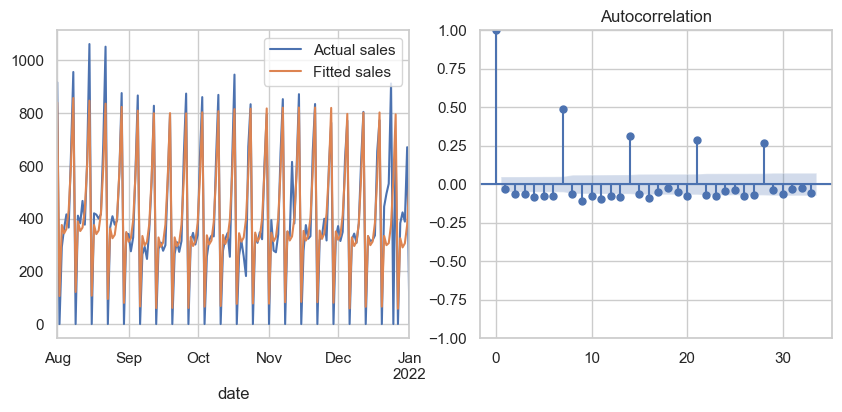

In [72]:
fix, axs = plt.subplots(1, 2, figsize=(10, 4))

daily_quantity["2021-08-01":"2022-01-01"].plot(ax=axs[0])
fitted_d_sales["2021-08-01":"2022-01-01"].plot(ax=axs[0])

residuals = daily_quantity - fitted_d_sales
plot_acf(residuals, ax=axs[1])
axs[0].legend(['Actual sales', 'Fitted sales']);

In [73]:
import pmdarima as pm

model = pm.auto_arima(residuals, seasonal=True, m=7)

model.get_params()

# order:(1, 0, 0)
# seasonal_order: (1, 0, 2, 7)

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 2, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(residuals, 
                        order=model.get_params()['order'], 
                        seasonal_order=model.get_params()['seasonal_order']).fit(disp=0)

final_fitted_d_quantity = daily_quantity + model_sarimax.get_prediction().summary_frame()['mean'].to_frame(name='quantity')

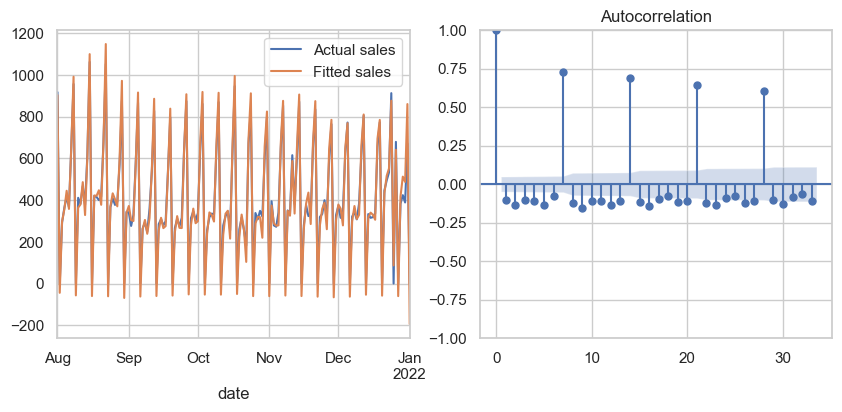

In [75]:
fix, axs = plt.subplots(1, 2, figsize=(10, 4))

daily_quantity["2021-08-01":"2022-01-01"].plot(ax=axs[0])
final_fitted_d_quantity["2021-08-01":"2022-01-01"].plot(ax=axs[0])

residuals = daily_quantity - final_fitted_d_quantity
plot_acf(residuals, ax=axs[1])
axs[0].legend(['Actual sales', 'Fitted sales']);

# Item sales

Here just an example for IT-11

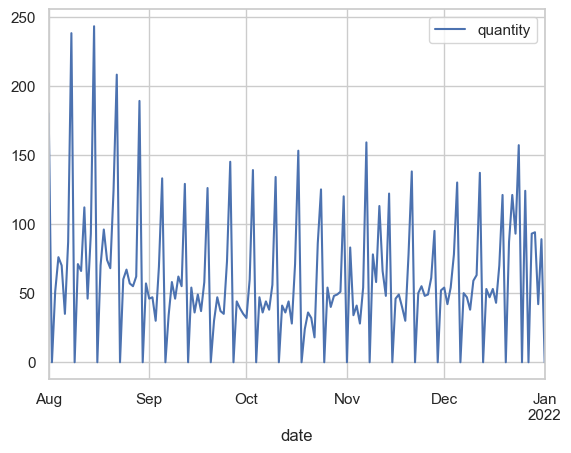

In [76]:
item_daily_quantity = data_f[(data_f['quantity'] < data_f['quantity'].quantile(0.99)) &
                             (data_f['quantity'] > data_f['quantity'].quantile(0.01)) &
                             (data_f['item_id'] == 'IT-11')].set_index('date').resample('D').sum()
item_daily_quantity = item_daily_quantity['quantity'].to_frame()

item_daily_quantity["2021-08-01":"2022-01-01"].plot();

In [77]:
item_daily_quantity_main = item_daily_quantity.copy()

item_daily_quantity.reset_index(inplace=True)
item_daily_quantity['weekday'] = item_daily_quantity['date'].dt.day_name()

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first').fit(item_daily_quantity['weekday'].values.reshape(-1, 1))
weekday = encoder.transform(item_daily_quantity['weekday'].values.reshape(-1, 1)).toarray()
weekday = pd.DataFrame(weekday, dtype=np.int16)
weekday.columns = encoder.get_feature_names_out(['weekday'])

del item_daily_quantity['date']

item_daily_quantity = pd.concat([
    item_daily_quantity,
    weekday
], axis=1)
del item_daily_quantity['weekday']

# item_daily_quantity = pd.get_dummies(item_daily_quantity, columns=['weekday'], drop_first=True)
# del item_daily_quantity['date']

In [78]:
import statsmodels.api as sm

X = item_daily_quantity.iloc[:,1:]
X = pd.concat([
    X,
    daily_quantity['quantity'].reset_index()['quantity']
], axis=1)
X = sm.add_constant(X)

y = item_daily_quantity['quantity']

model_daily_quantity = sm.OLS(y, X).fit()

print(model_daily_quantity.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     1279.
Date:                Tue, 09 May 2023   Prob (F-statistic):               0.00
Time:                        17:34:49   Log-Likelihood:                -6947.1
No. Observations:                1613   AIC:                         1.391e+04
Df Residuals:                    1605   BIC:                         1.395e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -18.2507      1.50

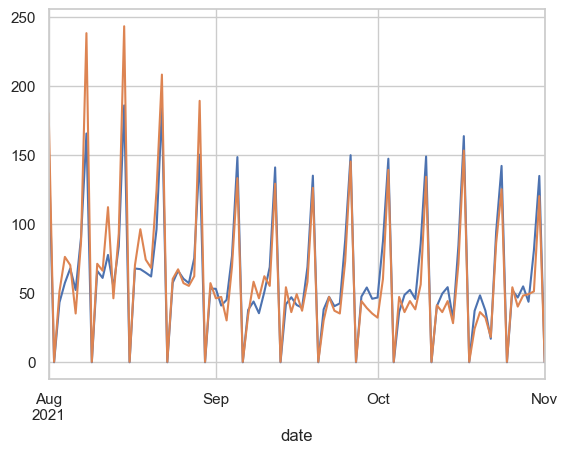

In [79]:
item_sales_prediction = model_daily_quantity.get_prediction().summary_frame()['mean'].to_frame(name='quantity')
item_sales_prediction.set_index(item_daily_quantity_main.index, inplace=True)

residuals = item_daily_quantity_main - item_sales_prediction

ax = plt.subplot()
item_sales_prediction.loc['2021-08-01':'2021-11-01', 'quantity'].plot(ax=ax)
item_daily_quantity_main.loc['2021-08-01':'2021-11-01', 'quantity'].plot(ax=ax);

In [80]:
import pmdarima as pm

model = pm.auto_arima(residuals, seasonal=True, m=7)

model.get_params()

# order:(0, 1, 1)
# seasonal_order: (1, 0, 1, 7)

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [81]:
model_sarimax = SARIMAX(residuals, 
                        order=(0, 1, 1), 
                        seasonal_order=(1, 0, 1, 7)).fit(disp=0)

final_item_sales_prediction = item_sales_prediction + model_sarimax.get_prediction().summary_frame()['mean'].to_frame(name='quantity')

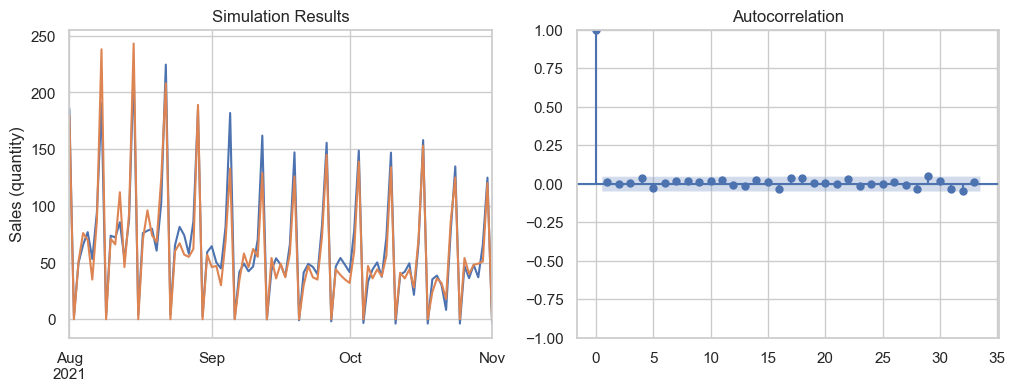

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

residuals = final_item_sales_prediction - item_daily_quantity_main

final_item_sales_prediction.loc['2021-08-01':'2021-11-01', 'quantity'].plot(ax=ax[0])
item_daily_quantity_main.loc['2021-08-01':'2021-11-01', 'quantity'].plot(ax=ax[0])
ax[0].set_title('Simulation Results')
ax[0].set_xlabel('')
ax[0].set_ylabel('Sales (quantity)')

plot_acf(residuals, ax=ax[1]);

# Test some ideas or functions

## Take future values of rolling

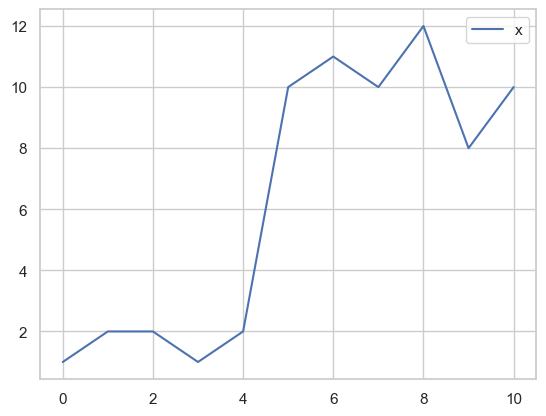

In [83]:
df = pd.DataFrame({
    'x': [1, 2, 2, 1, 2, 10, 11, 10, 12, 8, 10]
})
df.plot();

In [84]:
pd.concat([
    df,
    df.shift(-1).rolling(3, min_periods=1).mean(),
    df.rolling(window=2, min_periods=1).mean().shift(-1)
], axis=1)

,x,x,x
0,1,2.000,1.500
1,2,2.000,2.000
2,2,1.667,1.500
3,1,1.667,1.500
4,2,4.333,6.000
5,10,7.667,10.500
6,11,10.333,10.500
7,10,11.000,11.000
8,12,10.000,10.000
9,8,10.000,9.000


## Get total sales

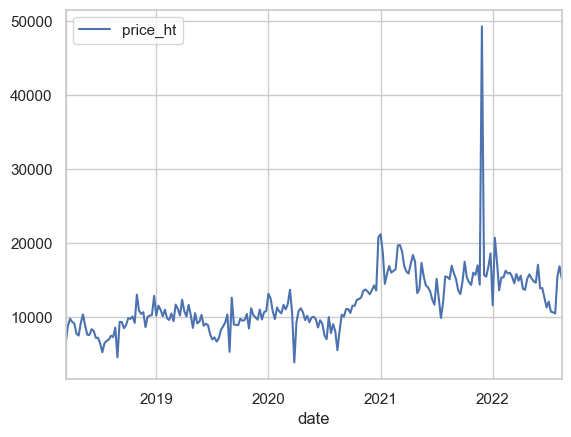

In [85]:
sales = data_f[['price_ht', 'date']].set_index('date').resample('W').sum()
sales.plot();

Very unstable trend, remove outliers

In [86]:
Q95 = data_f['price_ht'].quantile(0.95)
Q05 = data_f['price_ht'].quantile(0.05)

data_f = data_f[(data_f['price_ht'] < Q95) &
                (data_f['price_ht'] > Q05)]

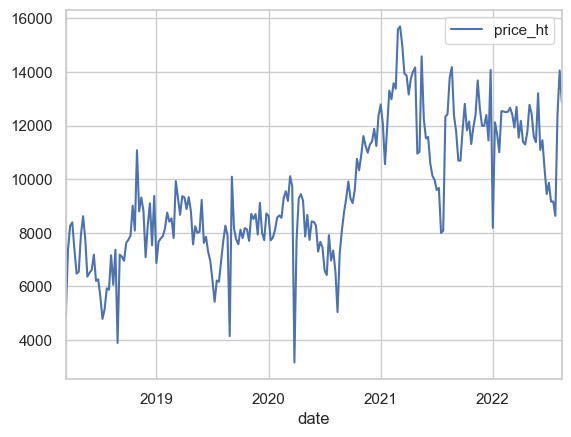

In [87]:
sales = data_f[['price_ht', 'date']].set_index('date').resample('W').sum()
sales.plot();

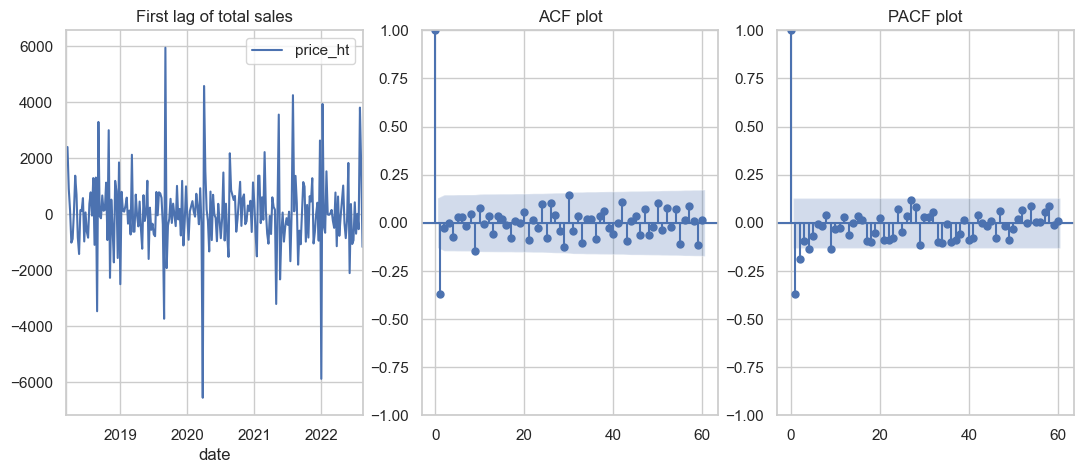

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 5))

sales.diff().plot(title='First lag of total sales', ax=ax1)
plot_acf(sales.diff().dropna(), title='ACF plot', ax=ax2, lags=60)
plot_pacf(sales.diff().dropna(), title='PACF plot', ax=ax3, lags=60, method='ywm');

In [89]:
from statsmodels.tsa.stattools import kpss, adfuller

<center>KPSS test:</center>
$$
H_0: \text{The process is trend stationary}\\
H_1: \text{The series has a unit root}
$$

In [90]:
kpss(sales.diff().dropna())[1]

0.1

In [91]:
data_f = data_f[(data_f['price_ht'] < Q95) &
                (data_f['price_ht'] > Q05)]



<center>ADF test:</center>
$$
H_0: \text{Has unit root process}\\
H_1: \text{Has no unit root process}
$$

### Some random ARIMA model

                               SARIMAX Results                                
Dep. Variable:               price_ht   No. Observations:                  231
Model:                 ARIMA(3, 4, 1)   Log Likelihood               -2053.577
Date:                Tue, 09 May 2023   AIC                           4117.155
Time:                        17:35:38   BIC                           4134.280
Sample:                    03-18-2018   HQIC                          4124.065
                         - 08-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4196      0.042    -33.874      0.000      -1.502      -1.337
ar.L2         -1.0955      0.074    -14.730      0.000      -1.241      -0.950
ar.L3         -0.4280      0.058     -7.428      0.0

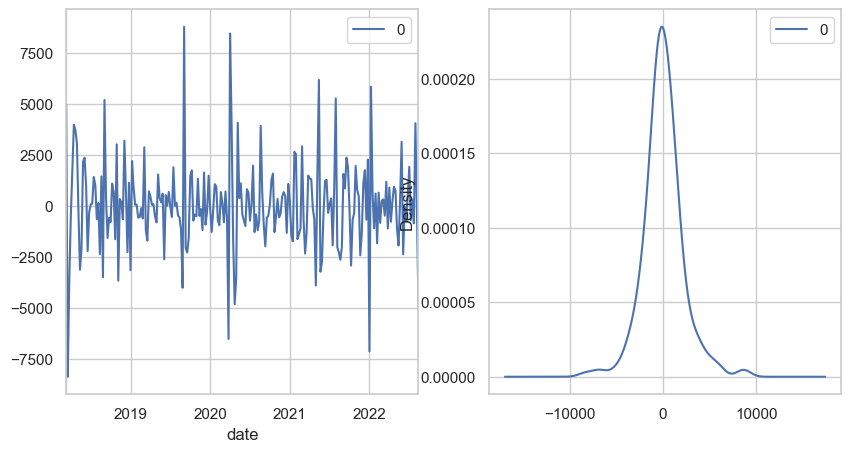

In [92]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

model = ARIMA(sales, order=(3,4,1))
model_fit = model.fit()

print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
print(residuals.describe())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
residuals.plot(ax=ax1)
residuals.plot(kind='kde', ax=ax2);

# MA (test, never used it)

In [93]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

mod = ARIMA(sales, order=(2, 3, 1))
res = mod.fit()

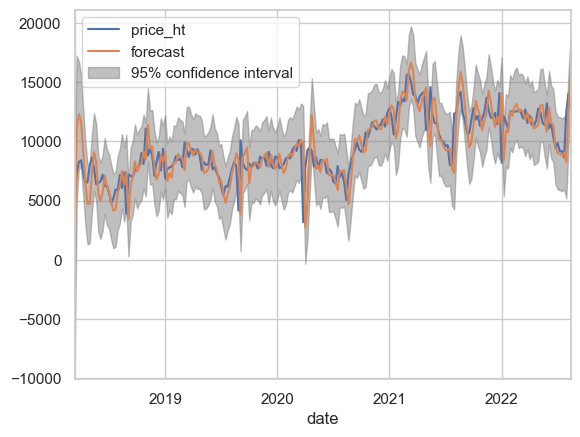

In [94]:
ax = plt.subplot()
sales.plot(ax=ax)
plot_predict(res, ax=ax);